In [217]:
from collections import Counter

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score
from statsmodels.formula.api import ols

In [238]:
def normalization(matrix):
    sum = np.sqrt(np.sum(matrix ** 2, axis=1, keepdims=True))
    nor_matrix = matrix / sum
    return nor_matrix


def spect_decomp(df, k):
    adjacentMatrix = np.array(df)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    LaplacianMatrix_normalized = np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)
    lam, H = np.linalg.eigh(LaplacianMatrix_normalized)

    t = np.argsort(lam)
    
    return lam, normalization(H[:,t[:k]])


def spect_clustering(df, decomp, number=20):
    lam, H = decomp(df, number)
    model = KMeans(n_clusters=number)
    model.fit(H)
    labels = model.labels_

    return labels

In [234]:
df_sem = pd.read_csv('./sem_dist.csv', index_col=0)
df_smi = pd.read_csv('./smi_dist.csv', index_col=0)
df_ato = pd.read_csv('./ato_dist.csv', index_col=0)

In [245]:
lam_sem,_ = spect_decomp(df_sem,1)
lam_smi,_ = spect_decomp(df_smi,1)
lam_ato,_ = spect_decomp(df_ato,1)

Text(0, 0.5, 'Eigenvalues')

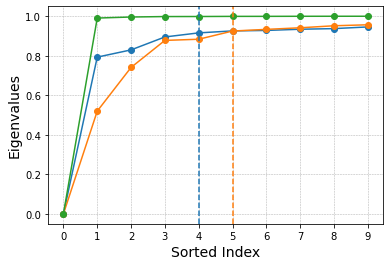

In [275]:
plt.plot(np.sort(lam_sem)[:10], '-o')
plt.plot(np.sort(lam_smi)[:10], '-o')
plt.plot(np.sort(lam_ato)[:10], '-o')
plt.axvline(x=4, ls='--', color='tab:blue')
plt.axvline(x=5, ls='--', color='tab:orange')
plt.xticks(np.arange(10));
plt.grid(lw=.5, ls='--')
plt.xlabel("Sorted Index", fontsize=14)
plt.ylabel("Eigenvalues", fontsize=14)

In [282]:
trials = 100
labels_sem = np.zeros((trials, 964))
labels_smi = np.zeros((trials, 964))
labels_ato = np.zeros((trials, 964))
for i in tqdm(range(trials)):
    labels_sem[i,:] = spect_clustering(df_sem, spect_decomp, 5)
    labels_smi[i,:] = spect_clustering(df_smi, spect_decomp, 6)
    labels_ato[i,:] = spect_clustering(df_ato, spect_decomp, 2)

100%|████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


In [192]:
import itertools
combs = list(itertools.combinations(np.arange(trials), 2))

In [283]:
AB = np.zeros(len(combs))
AC = np.zeros(len(combs))
BC = np.zeros(len(combs))

for t,(i,j) in enumerate(combs):
    AB[t] = adjusted_rand_score(labels_sem[i,:], labels_smi[j,:])
    AC[t] = adjusted_rand_score(labels_sem[i,:], labels_ato[j,:])
    BC[t] = adjusted_rand_score(labels_smi[i,:], labels_ato[j,:])

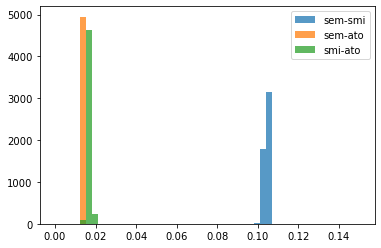

In [284]:
bins = np.linspace(0.,.15,50)
plt.hist(AB,bins, alpha=.75, label="sem-smi");
plt.hist(AC,bins, alpha=.75, label="sem-ato");
plt.hist(BC,bins, alpha=.75, label="smi-ato");
plt.legend()

In [281]:
AB.mean()

0.1047186926390205